# [Tensorflow 1.x] 신경망 Agent DQN 구현하기

In [1]:
import tensorflow as tf
import numpy as np
import random
import time
import pywrap_tensorflow
import _distributor_init
import _mklinit

from game import Game
from model import DQN

tf.app.flags.DEFINE_boolean("train", False, "학습모드. 게임을 화면에 보여주지 않습니다.")
FLAGS = tf.app.flags.FLAGS

In [2]:
# 하이퍼파라미터 설정
MAX_EPISODE = 10000   # 게임을 10000회 학습
TARGET_UPDATE_INTERVAL = 1000   # 목표신경망을 1000회마다 한번씩 갱신
TRAIN_INTERVAL = 4   # 4회 마다 한번씩 학습
OBSERVE = 100  # 일정수준의 학습 데이터가 쌓이기 전에는 학습하지 않고 지켜보기만 해라. 100번의 프레임이 지난 뒤부터 학습.

In [3]:
# 게임에 필요한 설정
NUM_ACTION = 3 #행도, 0:좌, 1:유지, 2:우
SCREEN_WIDTH = 6
SCREEN_HEIGHT = 10

In [4]:
#텐서플로 세션과 게임 객체, DQN 모델 객체 생성

def train():
    print('뇌세포 깨우는 중...')
    sess = tf.Session()
    
    game = Game(SCREEN_WIDTH, SCREEN_HEIGHT, show_game=False)
    brain = DQN(sess, SCREEN_WIDTH, SCREEN_HEIGHT, NUM_ACTION)
    
    # 학습 결과 저장 및 상태 확인 코드
    rewards = tf.placeholder(tf.float32, [None])
    tf.summary.scalar('avg.reward/ep.', tf.reduce_mean(rewards))   # 한 판마다 얻는 점수를 저장하고 확인
    
    saver = tf.train.Saver()   # 학습결과를 저정하기 위한 saver와 텐서플로 세션
    sess.run(tf.global_variables_initializerializer())
    
    writer = tf.summary.FileWriter('logs', sess.graph)  # 로그를 저장과 학습상태 확인 위한 텐서 설정
    summary_merged = tf.summary.merge_all()
    
    # 목표 신경망 초기화
    brain.update_target_network()
    # 행동을 선택할 때 DQN을 이용할 시점을 정한다. 학습 초반에는 항상 같은 값만 내놓는 DQN이지만, 일정 시간 지나기 전에는 행동을 무작위로 선택해야 한다.
    # 이를 위해 게임 진행중에 epsilon 값을 줄여나가는 코드를 넣는다.
    epsilon = 1.0  # 입실론 값은 무작위 상태코드 값인데, 게임 진행(학습진행) 할 수록 점점 사용 비율이 줄어든다.
    
    # 점수 저장 배열 초기화
    time_step =0 
    total_reward_list = []
    
    # 여기서부터 진짜 게임 진행하고 학습시키는 부분. 10000회 실행하며, 매 게임을 시작하기 전에 초기화
    #################################################################################################
    
    for episode in range(MAX_EPISODE):
        terminal = False
        total_reward = 0
        
        state = game.reset()   # 이 상태를 DQN의 초기 상태값에 넣어준다.
        brain.init_state(state)  # 화면크기 구성
        
    # 원래 DQN은 픽셀값들을 상태값으로 받지만, 여기서 사용하는 게임모듈에서는 해당 위치에 사각형이 있는지 없는지를 1과 0으로만 받는다.
    # 아래는 게임 한번 진행
        while not terminal:
            if np.random_read() < epsilon:
                action = random.randrange(NUM_ACTION)
            else:
                action = brain.get_action()
                
            if episode > OBSERVE:
                opsilon -= 1 / 1000
                
            state, reward, terminal = game.step(action)
            total_reward += reward
            
            brain.remember(state, action, reward, terminal) # 현재 상태를 신경망 객체에 기억시킵니다. 이 기억한 현재 상태를 이용해 다음 상태에서 취할 행동을 정합니다.
            
            if time_step > OBSERVE and time_step & TRAIN_INTERVAL == 0:
                brain.train()
            
            if time_step % TARGET_UPDATE_INTERVAL == 0:
                brain.update_target_network()
            
            time_step += 1
            
            print('게임횟수: %d 점수: %d' % (episode + 1, total_reward))
            
            total_reward_list.append(total_reward)
            
            if episode % 10 == 0:
                summary = sess.run(summary_merged, feed_dict={rewards: total_reward_list})
                writer.add_summary(summary, time_step)
                total_reward_list = []
                
            if episode % 100 == 0:
                saveer.save(sess, 'model1/dqn.ckpt', global_step=time_step)
                
############ 여기까지가 학습을 시키는 에이전트 코드 ############

In [5]:
# 학습 결과 실행 함수 작성 
# tf.train.Saver()로 저장해둔 모델을 읽어와서 생성한다.

def replay():
    print('뇌세포 깨우는 중...')
    sess = tf.Session()
    
    game = Game(SCREEN_WIDTH, SCREEN_HEIGHT, show_game=True)
    brain = DQN(sess, SCREEN_WIDTH, SCREEN_HEIGHT, NUM_ACTION)
    
    saver = tf.train.Saver()
    ckpt = tf.train.get_checkpoint_state('model')
    saver.restore(sess, ckpt.model_checkpoint_path)
    
    # 게임 진행 부분
    
    for episode in range(MAX_EPISODE):
        terminal = False
        total_reward = 0
        
        state = game.reset()
        brain.init_state(state)
        
        while not terminal:
            action = brain.get_action()
            
            state, reward, terminal = game.step(action)
            total_reward += reward
            
            brain.remember(state, action, reward, terminal)
            
            time.sleep(0.3)
            
        print('게임횟수: %d 점수: %d' % (episode + 1, total_reward))

뇌세포 깨우는 중...


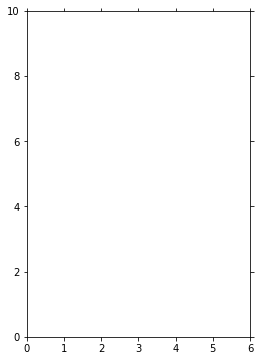

W0904 23:13:56.615809  7136 deprecation_wrapper.py:119] From C:\Users\fu\Documents\3minuts_TensorFlow-Tutorials-master\12 - DQN\model.py:33: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.



W0904 23:13:56.619808  7136 deprecation_wrapper.py:119] From C:\Users\fu\Documents\3minuts_TensorFlow-Tutorials-master\12 - DQN\model.py:47: The name tf.variable_scope is deprecated. Please use tf.compat.v1.variable_scope instead.



Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.


W0904 23:13:56.621806  7136 deprecation.py:323] From C:\Users\fu\Documents\3minuts_TensorFlow-Tutorials-master\12 - DQN\model.py:48: conv2d (from tensorflow.python.layers.convolutional) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


W0904 23:13:56.625805  7136 deprecation.py:506] From C:\Users\fu\Anaconda3\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
I0904 23:13:58.479652  7136 utils.py:141] NumExpr defaulting to 4 threads.


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



W0904 23:13:59.512014  7136 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



Instructions for updating:
Use keras.layers.flatten instead.


W0904 23:13:59.514011  7136 deprecation.py:323] From C:\Users\fu\Anaconda3\lib\site-packages\tensorflow\contrib\layers\python\layers\layers.py:1634: flatten (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.flatten instead.


Instructions for updating:
Use keras.layers.dense instead.


W0904 23:13:59.764858  7136 deprecation.py:323] From C:\Users\fu\Documents\3minuts_TensorFlow-Tutorials-master\12 - DQN\model.py:51: dense (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.dense instead.


W0904 23:14:00.102648  7136 deprecation_wrapper.py:119] From C:\Users\fu\Documents\3minuts_TensorFlow-Tutorials-master\12 - DQN\model.py:63: The name tf.train.AdamOptimizer is deprecated. Please use tf.compat.v1.train.AdamOptimizer instead.



Instructions for updating:
Use standard file APIs to check for files with this prefix.


W0904 23:14:00.461423  7136 deprecation.py:323] From C:\Users\fu\Anaconda3\lib\site-packages\tensorflow\python\training\saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


INFO:tensorflow:Restoring parameters from model\dqn.ckpt-1708830


I0904 23:14:00.467420  7136 saver.py:1280] Restoring parameters from model\dqn.ckpt-1708830


In [ ]:
# 스크립트 학습용으로 실행할 지, 학습된 결과로 게임을 진행할 지 선택하는 부분
# 터미널이나 명령 프롬프트에서 스크립트를 실행할 때 train 옵션을 받아 정하게 함


def main(_):
    if FLAGS.train:
        train()
    else:
        replay()


if __name__ == '__main__':
    tf.app.run()